# Handwritten digit classification using autoencoders

- Autoencoders are a neural network architecture. They have same input and output shape and have a symmetric shape, with the vectors shrinking to form a small vector in the middle, which is called the "encoded vector", which is then expanded by a "decoder" network to get an output with the same shape as the input.

- They can be used to learn compressed encodings of data in an **unsupervised** environment (no need of labelled data). This is why they are called autoencoders. This training can be done by giving it some input and training it to retreive the same input from the encoded vector.

- They are used for 

1. Denoising
2. In generative networks
3. For transfer learning
and many more

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [1]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm

print(torch.__version__)

1.5.0


## Defining basic functions needed

In [2]:
# Converting images to tensors
transform = transforms.Compose([transforms.ToTensor()])
batchsize = 10000

# Loading training and test sets
TrainSet    = datasets.MNIST(root="../downloads/MNIST", train=True, download=True, transform=transform)
TrainLoader = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)
TestSet     = datasets.MNIST(root="../downloads/MNIST", train=False, download=True, transform=transform)
TestLoader  = torch.utils.data.DataLoader(TrainSet, batch_size=batchsize, shuffle=True, num_workers=0)

classes    = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


## Defining the autoencoder

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100, 28*28), nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


## Defining optimizer

In [5]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1.5, momentum=0.5)

## Training the autoencoder

  0%|          | 0/50 [00:00<?, ?it/s]

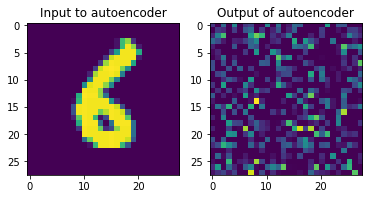

Loss : 0.000000
  2%|▏         | 1/50 [00:04<03:37,  4.43s/it]

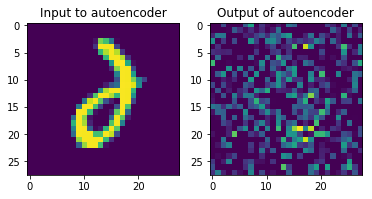

Loss : 0.000000
  4%|▍         | 2/50 [00:08<03:30,  4.39s/it]

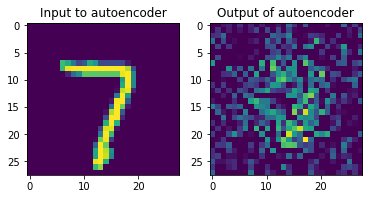

Loss : 0.000000
  6%|▌         | 3/50 [00:12<03:24,  4.34s/it]

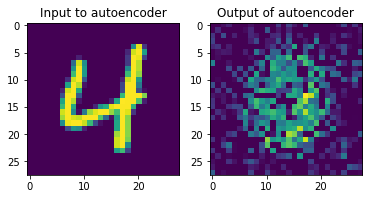

Loss : 0.000000
  8%|▊         | 4/50 [00:17<03:20,  4.35s/it]

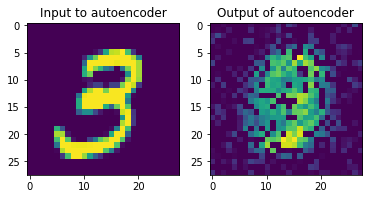

Loss : 0.000000
 10%|█         | 5/50 [00:21<03:16,  4.37s/it]

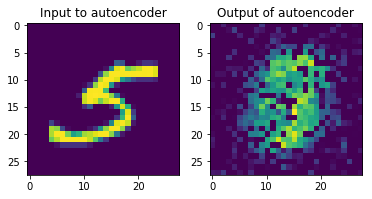

Loss : 0.000000
 12%|█▏        | 6/50 [00:26<03:15,  4.45s/it]

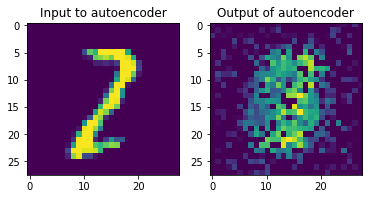

Loss : 0.000000
 14%|█▍        | 7/50 [00:30<03:09,  4.41s/it]

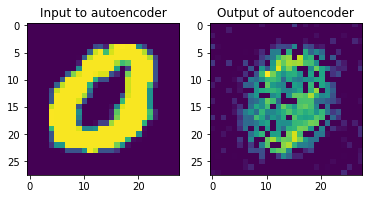

Loss : 0.000000
 16%|█▌        | 8/50 [00:35<03:04,  4.39s/it]

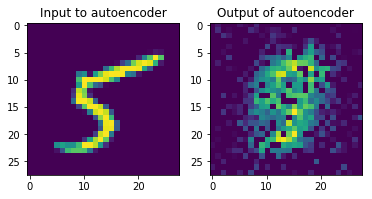

Loss : 0.000000
 18%|█▊        | 9/50 [00:39<03:00,  4.40s/it]

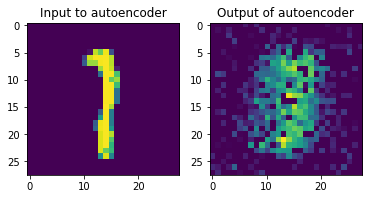

Loss : 0.000000
 20%|██        | 10/50 [00:43<02:55,  4.38s/it] Iteration  10/ 50, loss was 0.000000


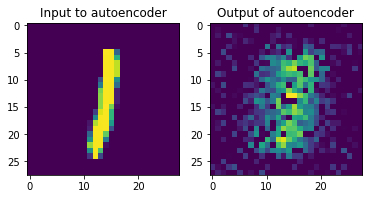

Loss : 0.000000
 22%|██▏       | 11/50 [00:48<02:50,  4.37s/it]

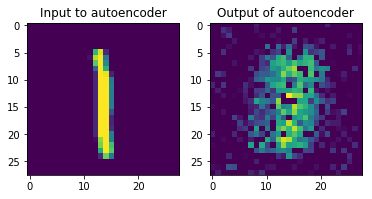

Loss : 0.000000
 24%|██▍       | 12/50 [00:52<02:46,  4.39s/it]

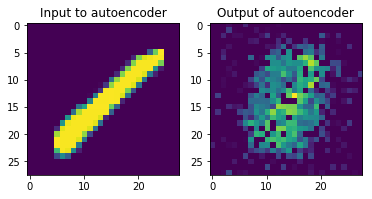

Loss : 0.000000
 26%|██▌       | 13/50 [00:56<02:41,  4.37s/it]

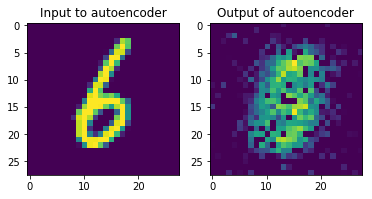

Loss : 0.000000
 28%|██▊       | 14/50 [01:01<02:37,  4.38s/it]

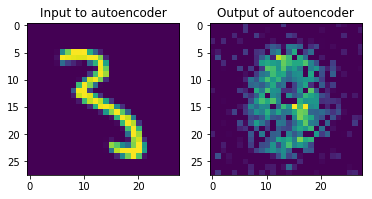

Loss : 0.000000
 30%|███       | 15/50 [01:05<02:33,  4.38s/it]

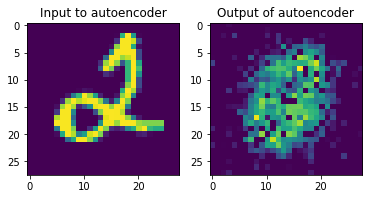

Loss : 0.000000
 32%|███▏      | 16/50 [01:10<02:29,  4.39s/it]

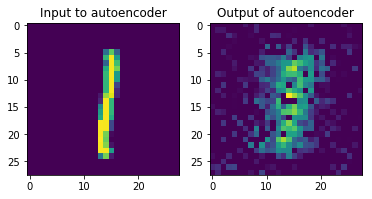

Loss : 0.000000
 34%|███▍      | 17/50 [01:14<02:24,  4.39s/it]

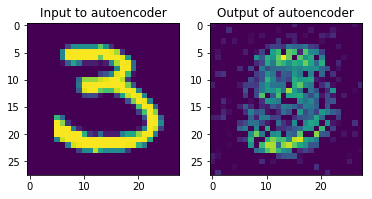

Loss : 0.000000
 36%|███▌      | 18/50 [01:18<02:20,  4.38s/it]

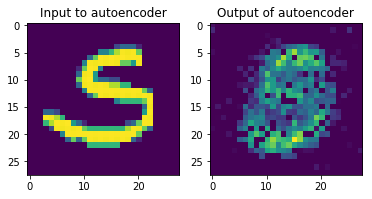

Loss : 0.000000
 38%|███▊      | 19/50 [01:23<02:15,  4.38s/it]

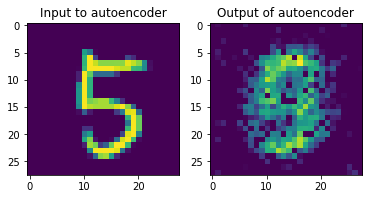

Loss : 0.000000
 40%|████      | 20/50 [01:27<02:11,  4.39s/it] Iteration  20/ 50, loss was 0.000000


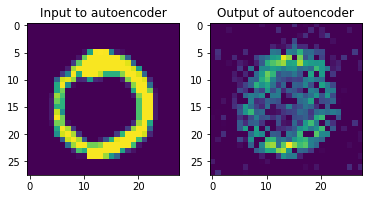

Loss : 0.000000
 42%|████▏     | 21/50 [01:31<02:06,  4.36s/it]

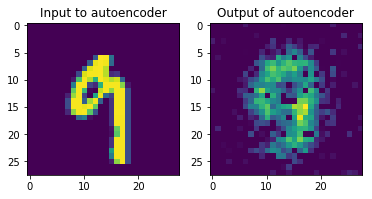

Loss : 0.000000
 44%|████▍     | 22/50 [01:36<02:02,  4.37s/it]

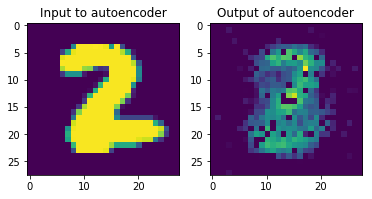

Loss : 0.000000
 46%|████▌     | 23/50 [01:40<01:57,  4.35s/it]

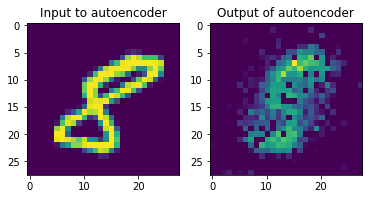

Loss : 0.000000
 48%|████▊     | 24/50 [01:44<01:53,  4.35s/it]

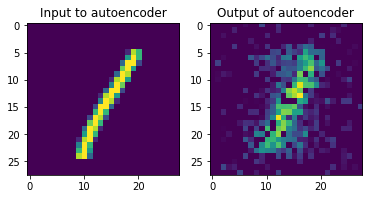

Loss : 0.000000
 50%|█████     | 25/50 [01:49<01:48,  4.35s/it]

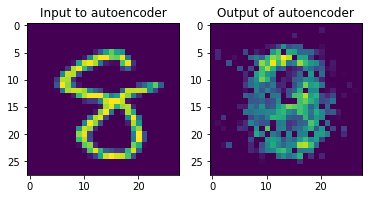

Loss : 0.000000
 52%|█████▏    | 26/50 [01:53<01:45,  4.38s/it]

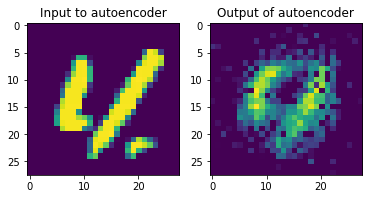

Loss : 0.000000
 54%|█████▍    | 27/50 [01:58<01:41,  4.41s/it]

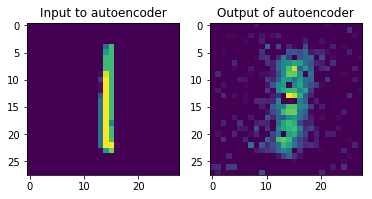

Loss : 0.000000
 56%|█████▌    | 28/50 [02:02<01:36,  4.39s/it]

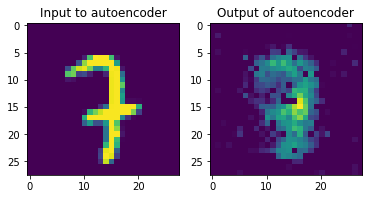

Loss : 0.000000
 58%|█████▊    | 29/50 [02:06<01:32,  4.38s/it]

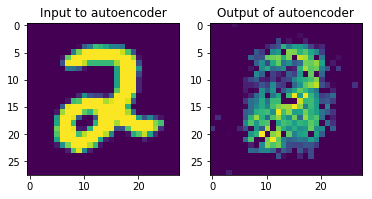

Loss : 0.000000
 60%|██████    | 30/50 [02:11<01:28,  4.42s/it] Iteration  30/ 50, loss was 0.000000


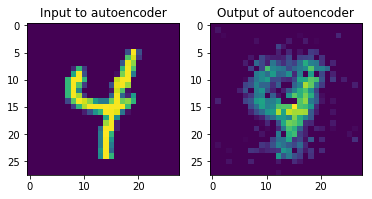

Loss : 0.000000
 62%|██████▏   | 31/50 [02:15<01:24,  4.44s/it]

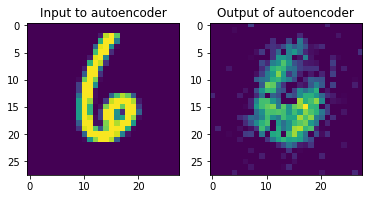

Loss : 0.000000
 64%|██████▍   | 32/50 [02:20<01:19,  4.43s/it]

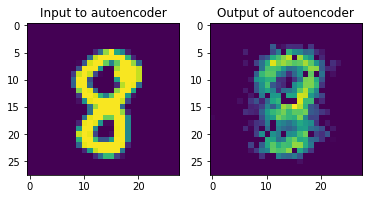

Loss : 0.000000
 66%|██████▌   | 33/50 [02:24<01:14,  4.40s/it]

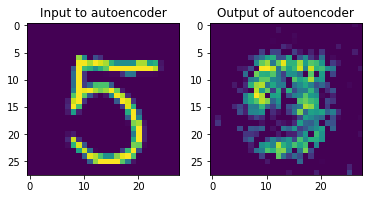

Loss : 0.000000
 68%|██████▊   | 34/50 [02:29<01:10,  4.40s/it]

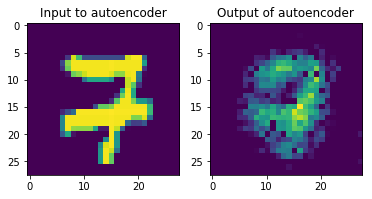

Loss : 0.000000
 70%|███████   | 35/50 [02:33<01:06,  4.40s/it]

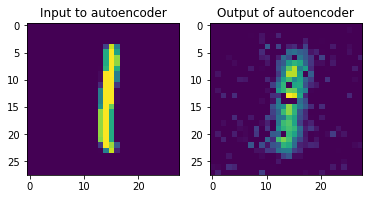

Loss : 0.000000
 72%|███████▏  | 36/50 [02:38<01:02,  4.44s/it]

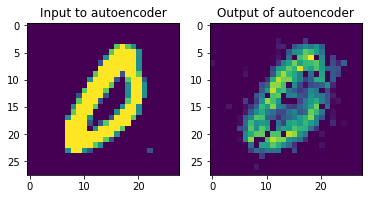

Loss : 0.000000
 74%|███████▍  | 37/50 [02:42<00:57,  4.45s/it]

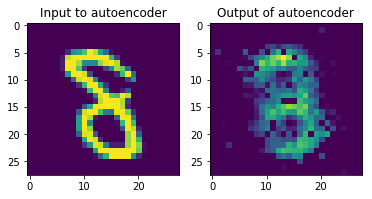

Loss : 0.000000
 76%|███████▌  | 38/50 [02:46<00:53,  4.45s/it]

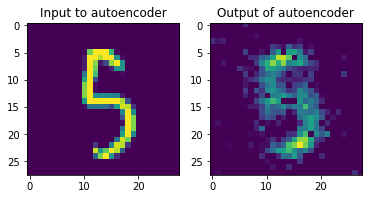

Loss : 0.000000
 78%|███████▊  | 39/50 [02:51<00:48,  4.41s/it]

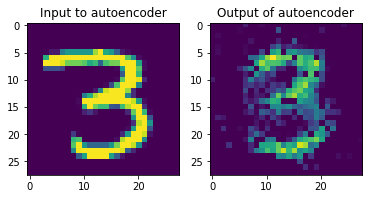

Loss : 0.000000
 80%|████████  | 40/50 [02:55<00:43,  4.38s/it] Iteration  40/ 50, loss was 0.000000


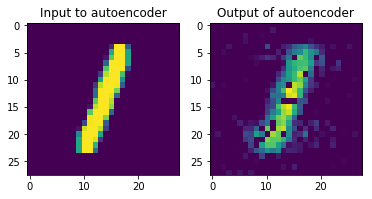

Loss : 0.000000
 82%|████████▏ | 41/50 [02:59<00:39,  4.38s/it]

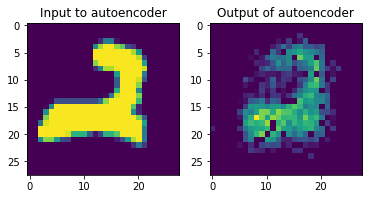

Loss : 0.000000
 84%|████████▍ | 42/50 [03:04<00:35,  4.41s/it]

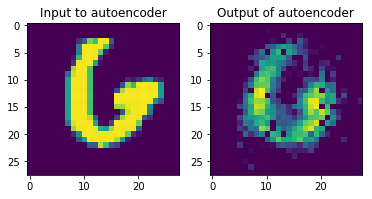

Loss : 0.000000
 86%|████████▌ | 43/50 [03:08<00:30,  4.43s/it]

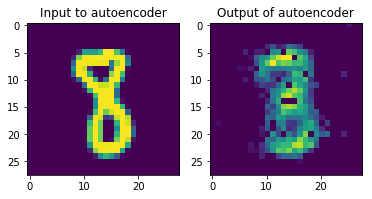

Loss : 0.000000
 88%|████████▊ | 44/50 [03:13<00:26,  4.42s/it]

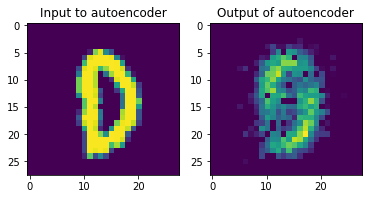

Loss : 0.000000
 90%|█████████ | 45/50 [03:17<00:22,  4.43s/it]

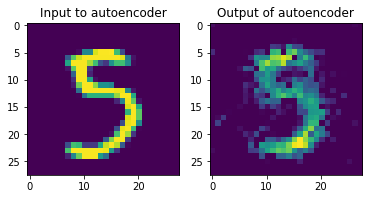

Loss : 0.000000
 92%|█████████▏| 46/50 [03:22<00:17,  4.45s/it]

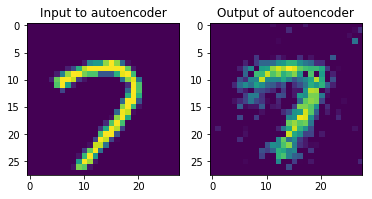

Loss : 0.000000
 94%|█████████▍| 47/50 [03:26<00:13,  4.43s/it]

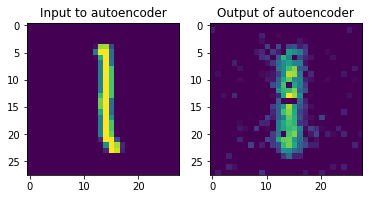

Loss : 0.000000
 96%|█████████▌| 48/50 [03:30<00:08,  4.41s/it]

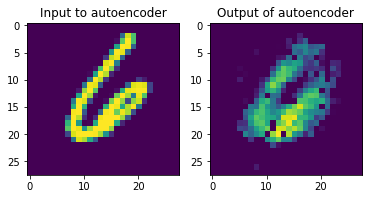

Loss : 0.000000
 98%|█████████▊| 49/50 [03:35<00:04,  4.40s/it]

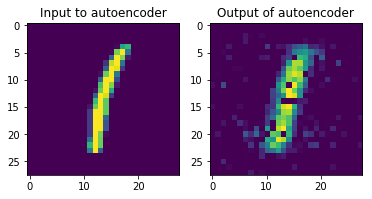

Loss : 0.000000
100%|██████████| 50/50 [03:39<00:00,  4.39s/it] Iteration  50/ 50, loss was 0.000000



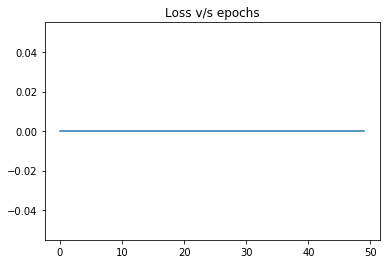

Finished training


In [7]:
iterations = 50

# Set this to true to view the input, noised input, and output of the autoencoder for each epoch
debug = True

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i, data in enumerate(TrainLoader):
        inputs, labels = data
        inputs = inputs.double().view(-1,28*28).to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        runningLoss += int(loss.item())

        if(debug and i == 0):
            plt.subplot(121)
            plt.imshow(inputs[0].view(28,28).cpu())
            plt.title("Input to autoencoder")

            plt.subplot(122)
            plt.imshow(outputs[0].view(28,28).cpu().detach())
            plt.title("Output of autoencoder")

            plt.show()

            print("Loss : %f"%(runningLoss/batchsize))

    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, loss was %f"%(epoch+1, iterations, runningLoss))

print("Finished training")

## Visualising result


Test set index number : 2045


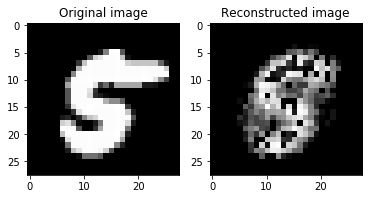


Test set index number : 8055


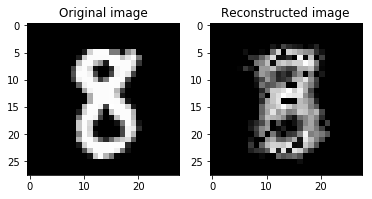


Test set index number : 8774


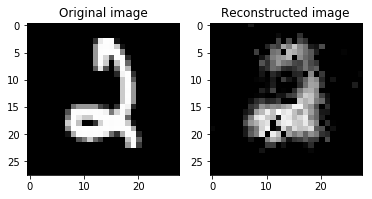


Test set index number : 2205


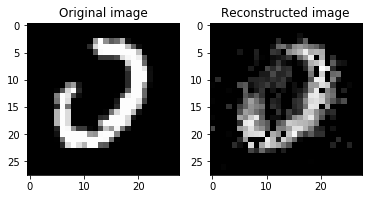


Test set index number : 6773


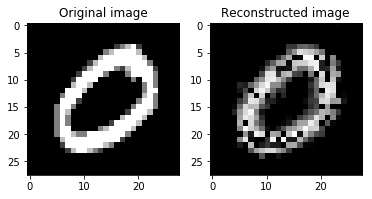


Test set index number : 806


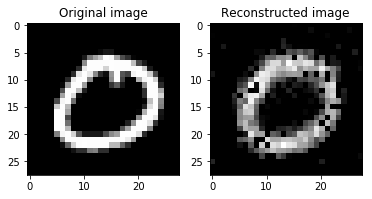


Test set index number : 3622


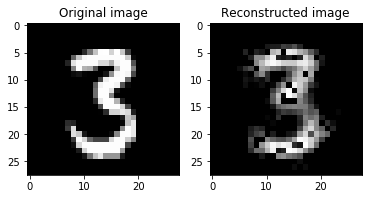


Test set index number : 4888


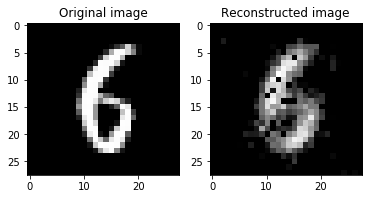


Test set index number : 8576


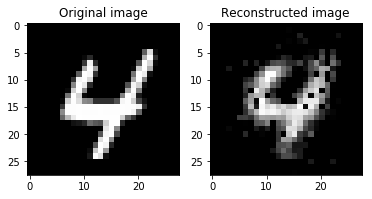


Test set index number : 6222


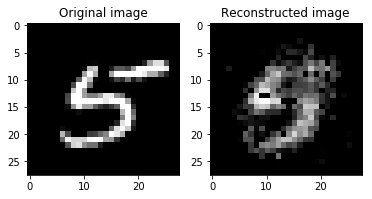

In [17]:
TestImages, _ = list(TrainLoader)[0]
indices = np.random.uniform(0, TestImages.shape[0], size=10)

for i in indices:
    print()
    print("Test set index number : %d"%i)

    test_img = TestImages[int(i)]

    test_noise = 100

    out = net((test_img.double().to(device).view(28*28)))
    output_img = (out.data*255).byte()
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Original image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    out_img = np.array(output_img.numpy())[0]
    plt.title("Reconstructed image")
    plt.imshow(out_img, cmap="gray")

    plt.show()

## Encoder weights visualisation

In [18]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

Text(0.5,1,'Updation of weights')

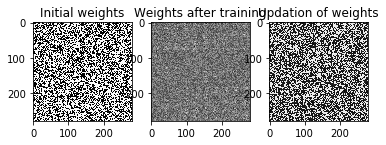

In [19]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

if use_gpu:
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = init_weights - trained_weights

plt.subplot(131)
plt.imshow(init_weights.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights.numpy()[0], cmap="gray")
plt.title("Updation of weights")

## Adding classification layer

In [20]:
classifier = nn.Sequential()
classifier_net = classifier
classifier_net.add_module("encoder_copy", list(net.children())[0])
classifier_net.add_module("classifier", nn.Sequential(nn.Linear(100,10), nn.LogSoftmax(dim=1)))

# Locking the encoder layer (its values will not be changed during training)
lock = False
for i in list(classifier_net.children())[0][0].parameters():
    i.requires_grad = not lock

classifier_net.double().to(device)

init_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

## Defining optimizer again

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(classifier_net.parameters(), lr=0.01, momentum=0.9)

## Training the clasiffier

In [25]:
iterations = 120

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i, data in enumerate(TrainLoader):
        inputs, labels = data
        inputs = inputs.double().to(device).view(-1,28*28)

        optimizer.zero_grad()
        outputs = classifier_net(inputs)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        runningLoss += int(loss.item())

    if(epoch % 10 == 9):        
        print(" Iteration %3d/%3d, loss was %f"%(epoch+1, iterations, runningLoss))

print("Finished training")

100%|██████████| 120/120 [08:12<00:00,  4.10s/it] Iteration 120/120, loss was 0.000000
Finished training



## Encoder weights visualisation (again)

In [29]:
trained_weights_2 = copy.deepcopy(classifier_net[0][0].weight.data)

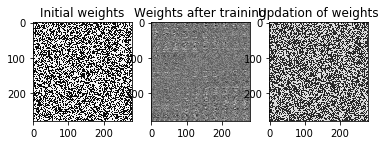

In [30]:
init_weights_2 = (1 + init_weights_2)*127.5
trained_weights_2 = (1 + trained_weights_2)*127.5

if use_gpu:
    init_weights_2 = init_weights_2.view(-1, 280, 280).byte().cpu()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte().cpu()
else:
    init_weights_2 = init_weights_2.view(-1,280,280).byte()
    trained_weights_2 = trained_weights_2.view(-1, 280, 280).byte()

d_weights_2 = init_weights_2 - trained_weights_2

plt.subplot(131)
plt.imshow(init_weights_2.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights_2.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights_2.numpy()[0], cmap="gray")
plt.title("Updation of weights")

plt.show()

## Output visualisation

Test set index no : 9428


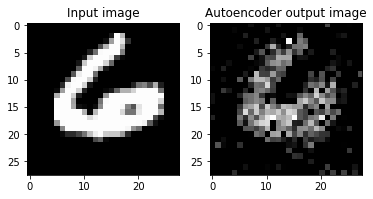

tensor(6)
 Output of classifier : 6 
 Label : 6 

Test set index no : 2089


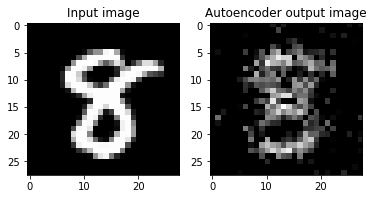

tensor(8)
 Output of classifier : 8 
 Label : 8 

Test set index no : 9026


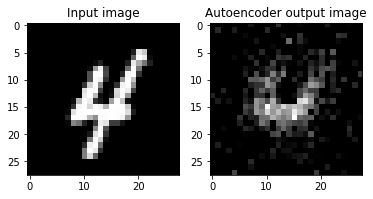

tensor(4)
 Output of classifier : 4 
 Label : 4 

Test set index no : 7844


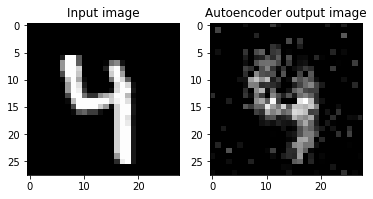

tensor(4)
 Output of classifier : 4 
 Label : 4 

Test set index no : 6881


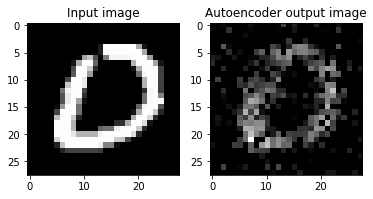

tensor(0)
 Output of classifier : 0 
 Label : 0 

Test set index no : 1278


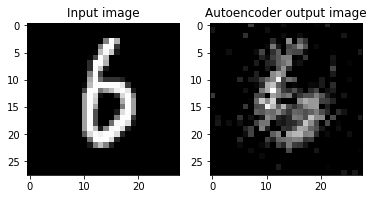

tensor(6)
 Output of classifier : 6 
 Label : 6 

Test set index no : 7288


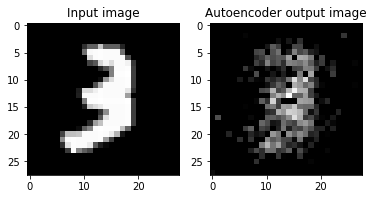

tensor(3)
 Output of classifier : 3 
 Label : 3 

Test set index no : 5467


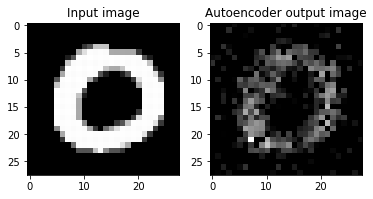

tensor(0)
 Output of classifier : 0 
 Label : 0 

Test set index no : 6828


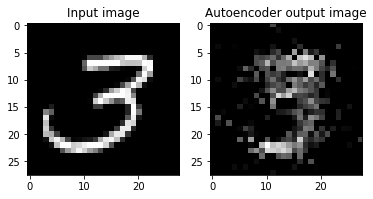

tensor(3)
 Output of classifier : 3 
 Label : 3 

Test set index no : 2773


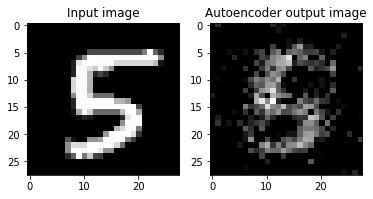

tensor(5)
 Output of classifier : 5 
 Label : 5 



In [42]:
TestImages, TestLabels = list(TestLoader)[0]
indices = np.random.uniform(0,TestImages.shape[0],size=10)

for index in indices:
    index = int(index)

    print("Test set index no : %d"%index)

    test_img = TestImages[index]
    label = TestLabels[index]

    output = classifier_net((test_img.double().to(device)).view(1,28*28))
    output_img = net((test_img.double().to(device)).view(1,28*28)).data
    output_img = output_img
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output = output.cpu()
        output_img = output_img.cpu()

    test_img = test_img.view(-1, 28, 28)

    plt.subplot(1,2,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Input image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,2,2)
    img = np.array(output_img.numpy())[0]
    plt.title("Autoencoder output image")
    plt.imshow(img, cmap="gray")
    plt.show()
    
    print(" Output of classifier : %d "%np.argmax(output.detach().numpy()))
    print(" Label : %d "%label)
    print()

## Test set performance

 Basic statistics :

  zero - tests :  980, Accuracy : 97.76 %
   one - tests : 1135, Accuracy : 97.80 %
   two - tests : 1032, Accuracy : 89.05 %
 three - tests : 1010, Accuracy : 91.09 %
  four - tests :  982, Accuracy : 93.18 %
  five - tests :  892, Accuracy : 86.43 %
   six - tests :  958, Accuracy : 94.26 %
 seven - tests : 1028, Accuracy : 91.93 %
 eight - tests :  974, Accuracy : 89.12 %
  nine - tests : 1009, Accuracy : 89.79 %



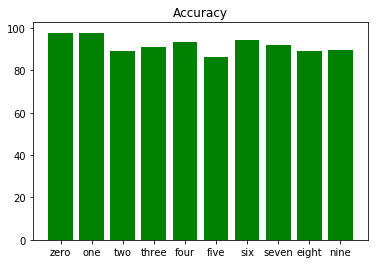


confusion matrix

Lab\Out|  zero |   one |   two | three |  four |  five |   six | seven | eight |  nine 
-------------------------------------------------------------------------------------
  zero | 97.76 |  0.00 |  0.31 |  0.20 |  0.00 |  0.41 |  0.82 |  0.20 |  0.31 |  0.00 
   one |  0.00 | 97.80 |  0.18 |  0.18 |  0.00 |  0.18 |  0.35 |  0.18 |  1.15 |  0.00 
   two |  0.97 |  0.68 | 89.05 |  1.45 |  1.16 |  0.19 |  1.16 |  1.26 |  3.39 |  0.68 
 three |  0.30 |  0.00 |  2.18 | 91.09 |  0.00 |  2.57 |  0.10 |  1.39 |  1.68 |  0.69 
  four |  0.10 |  0.20 |  0.31 |  0.20 | 93.18 |  0.00 |  1.22 |  0.20 |  0.81 |  3.77 
  five |  1.12 |  0.34 |  0.67 |  4.37 |  1.12 | 86.43 |  1.79 |  0.56 |  2.91 |  0.67 
   six |  1.46 |  0.31 |  0.42 |  0.10 |  1.46 |  1.46 | 94.26 |  0.31 |  0.21 |  0.00 
 seven |  0.29 |  0.78 |  2.24 |  0.58 |  0.49 |  0.00 |  0.00 | 91.93 |  0.29 |  3.40 
 eight |  1.03 |  0.62 |  0.51 |  2.26 |  0.92 |  2.36 |  1.13 |  1.23 | 89.12 |  0.82 
  nine |  0.99 

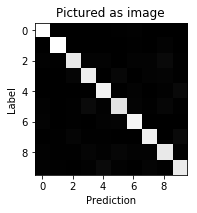

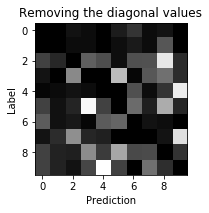

In [131]:
confusion_mat = np.zeros((10,11)).astype(np.int)

for data in TestSet:
    input, label = data

    output = classifier_net(input.to(device).double().view(-1,28*28))

    confusion_mat[label][10] += 1

    confusion_mat[label][np.argmax(output.cpu().detach())] += 1

print(" Basic statistics :")
print()
for i in range(10):
    print(" %5s - tests : %4d, Accuracy : %4.2f %%"%(classes[i], confusion_mat[i,-1], 100*confusion_mat[i,i]/confusion_mat[i,-1]))

print()

plt.title("Accuracy")
plt.bar(classes, 100*np.diag(confusion_mat)/confusion_mat[:,-1], color='g')
plt.show()

print()
print("confusion matrix")
print()

print("Lab\Out", end='')

for i in range(10):
    print("| %5s "%classes[i], end='')
print()

for i in range(85):
    print('-', end='')
print()

for i in range(10):
    print("%6ls "%classes[i], end='')
    for j in range(10):
        print("| %5.2f "%(100*confusion_mat[i][j]/confusion_mat[i][10]), end='')
    print()

for i in range(85):
    print('-', end='')
print()

plt.subplot(1,2,1)
plt.title("Pictured as image")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.imshow(confusion_mat[:,:-1]/confusion_mat[:,-1], cmap="gray")
plt.show()

plt.subplot(1,2,2)
plt.title("Removing the diagonal values")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.imshow((confusion_mat[:,:-1]/confusion_mat[:,-1])*(np.ones((10,10))-np.eye(10)), cmap="gray")
plt.show()

## What if?!

While training the classifier, the encoder layer was also trained. This is why the autoencoder output is more noisier than before. This can be solved by 

1. Copying the encoder layer using copy.deepcopy() for creating the classifier
2. Freeezing the encoder layer  while training the classifier
3. Freezing the encoder layer and train the autoencoder again (this time, only decoder layer will be trained) to improve reconstruction

However, both of these are unnecessary since the reconstructed autoencoder output is not used in our use case (recognising digits).

Just for curiosity, run this block to lock the encoder layer and run the auotencoder training code again to improve reconstructon without affecting classification performance. Not freezing the encoder layer will mess up the classification performance, since the classification layer was optimized for the other version of the encoder. While forming the classification layer, there is some code that can lock or unlock the encoder layer for the same purpose.

In [154]:
# Setting the requires_grad option in a layer enables training that layer using gradient descent. 
list(list(net.children())[0][0].parameters())[0].requires_grad = True

Check this [link](https://pytorch.org/docs/stable/notes/autograd.html) to see how requires_grad freezes layers and how automatic differentiation works in pytorch.